In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter
from matplotlib import style
import seaborn as sns
from datetime import date

In [19]:
sns.set()
sns.set_style('dark')
sns.set_palette(sns.color_palette('muted'))
fig = plt.figure()
fig.patch.set_alpha(0.0)


<Figure size 432x288 with 0 Axes>

In [20]:
# Basic styling
pd.set_option('display.width', 200)

In [39]:
#Load the data
try:
    import os
    from binance import Client
    api_key = os.environ.get('BINANCE_TEST_API')
    api_secret = os.environ.get('BINANCE_TEST_SECRET')
    client=client = Client(api_key, api_secret)
    btc=client.get_historical_klines("BTCUSDT", Client.KLINE_INTERVAL_1DAY, "600 day ago UTC+0")
    print("Using data from Binance stream")
except:
    print("Data from Binance stream unsuccessful\n")
    print("Now reading from stored streams\n")
    try:
        #Try reading from local file
        link="E:\Intellectual Content\GMT\Gig-Econ\Strategic Programmer\Crypto API\Crypto-API-SP-\Auto Investing DCA strategy\DCA scripts\Binance_QTUMUSDT_d.csv"
    except:
        #Try reading from external site
        link="https://www.cryptodatadownload.com/cdd/Binance_BTCUSDT_d.csv"
    btc = pd.read_csv(link, skiprows=1, usecols=['date', 'close','open'])
    print("Successfully read the data from CSV file")
    #Index dataset by date
    btc['date'] = pd.to_datetime(btc['date'])
    btc = btc.set_index('date')
    btc = btc.sort_index()


Data from Binance stream unsuccessful

Now reading from stored streams

Successfully read the data from CSV file


In [22]:
today=date.today()
today_date=today.strftime("%Y-%m-%d")
btc=btc.loc[:today_date]
#btc=btc.reshape(-1,1)
# print results
#print(btc.tail())
data= btc.tail(n=25)
print(data)
btc_open_data=data.open.values.reshape(-1,1)
btc_close_data=data.close.values.reshape(-1,1)


             open  close
date                    
2022-03-24  7.882  7.865
2022-03-25  7.866  8.303
2022-03-26  8.293  8.237
2022-03-27  8.235  8.496
2022-03-28  8.493  8.175
2022-03-29  8.187  8.349
2022-03-30  8.349  8.869
2022-03-31  8.879  8.275
2022-04-01  8.281  8.445
2022-04-02  8.441  8.311
2022-04-03  8.316  8.508
2022-04-04  8.514  8.241
2022-04-05  8.244  7.800
2022-04-06  7.811  6.919
2022-04-07  6.915  7.239
2022-04-08  7.236  6.817
2022-04-09  6.812  7.074
2022-04-10  7.073  6.803
2022-04-11  6.812  6.195
2022-04-12  6.196  6.433
2022-04-13  6.440  6.767
2022-04-14  6.767  6.549
2022-04-15  6.550  6.616
2022-04-16  6.618  6.896
2022-04-17  6.894  6.861


In [23]:
def doDCAmonthly(investment, start_date, periods, freq):
    investment_dates_all = pd.date_range(start_date,periods=periods,freq=freq)
    # Remove those dates beyond our known data range
    investment_dates = investment_dates_all[investment_dates_all < btc.index[-1]]

    # Get closest business dates with available data
    closest_investment_dates = btc.index.searchsorted(investment_dates)

    # How much to invest on each date
    portion = investment/periods

    # Get the total of all stocks purchased for each of those dates (on the Close)
    stocks_invested = sum(portion / btc['close'][closest_investment_dates])

    # Add uninvested amount back
    uninvested_dollars = portion * sum(investment_dates_all >= btc.index[-1])

    # value of stocks today
    total_value = value_price*stocks_invested + uninvested_dollars
    return total_value

In [24]:
# CALCULATING THE VALUE OF DCA INVESTMENT
value_price = btc['close'][-1]
initial_investment =int(input("Enter your investment value: "))
value_price

6.861

In [25]:
# Generate DCA series for every possible date and investment strategy
dca_m = pd.Series(btc.index.map(lambda x: doDCAmonthly(initial_investment, x, 4, '30D')), index=btc.index, name='Monthly DCA')

dca_w = pd.Series(btc.index.map(lambda x: doDCAmonthly(initial_investment, x, 16, '7D')), index=btc.index, name='Weekly DCA')

dca_d = pd.Series(btc.index.map(lambda x: doDCAmonthly(initial_investment, x, 120, '1D')), index=btc.index, name='Daily DCA')


In [26]:
# Representing the strategies and plotting the data

dca = pd.concat([dca_d, dca_m, dca_w], axis=1)
diff_mw = dca['Monthly DCA'] - dca['Weekly DCA']
diff_wm= dca['Weekly DCA']- dca['Monthly DCA']
diff_md = dca['Monthly DCA'] - dca['Daily DCA']
diff_dm= dca['Daily DCA']-dca['Monthly DCA']
diff_wd = dca['Weekly DCA'] - dca['Daily DCA']
diff_dw= dca['Daily DCA']-dca['Weekly DCA']

In [27]:
# Monthly Investment and Statistical Significance
mean_mw=sum(diff_mw[diff_mw>0]) / sum(diff_mw>0)
mean_wm=sum(-diff_mw[diff_mw<0]) / sum(diff_mw<0)
percent_diff_mw=(100*sum(diff_mw>0)/len(diff_mw))
percent_diff_wm=(100*sum(diff_mw<0)/len(diff_mw))

print("Monthly DCA returns more than Weekly DCA %.1f%% of all the days" % percent_diff_mw)
print("Weekly DCA returns more than Monthly DCA %.1f%% of all the days" % percent_diff_wm)
print("Mean difference when Monthly DCA > Weekly DCA: ${:,.2f}".format(mean_mw))
print("Mean difference when Weekly DCA > Monthly DCA: ${:,.2f}".format(mean_wm))

Monthly DCA returns more than Weekly DCA 46.3% of all the days
Weekly DCA returns more than Monthly DCA 53.6% of all the days
Mean difference when Monthly DCA > Weekly DCA: $21.28
Mean difference when Weekly DCA > Monthly DCA: $19.41


In [28]:
# Calculation of Daily and Monthly Strategy
mean_md=sum(diff_md[diff_md>0]) / sum(diff_md>0)
mean_dm=sum(-diff_md[diff_md<0]) / sum(diff_md<0)
percent_diff_md=(100*sum(diff_md>0)/len(diff_md))
percent_diff_dm=(100*sum(diff_md<0)/len(diff_md))

print("Monthly DCA returns more than Daily DCA %.1f%% of all the days" % percent_diff_md)
print("Daily DCA returns more than Monthly DCA %.1f%% of all the days" % percent_diff_dm)

print("Mean difference: Average dollar improvement Monthly DCA returns vs. Daily DCA: ${:,.2f}".format(sum(diff_md) / len(diff_md)))
print("Mean difference when Monthly DCA > Daily DCA: ${:,.2f}".format(mean_md))
print("Mean difference when Daily DCA > Monthly DCA: ${:,.2f}".format(mean_dm))

Monthly DCA returns more than Daily DCA 43.9% of all the days
Daily DCA returns more than Monthly DCA 56.1% of all the days
Mean difference: Average dollar improvement Monthly DCA returns vs. Daily DCA: $-0.96
Mean difference when Monthly DCA > Daily DCA: $31.62
Mean difference when Daily DCA > Monthly DCA: $26.45


In [29]:
# Weekly versus Daily Strategies
percent_diff_wd=(100*sum(diff_wd>0)/len(diff_wd))
percent_diff_dw=(100*sum(diff_wd<0)/len(diff_wd))
mean_wd=sum(diff_wd[diff_wd>0]) / sum(diff_wd>0)
mean_dw=sum(-diff_wd[diff_wd<0]) / sum(diff_wd<0)
print("Weekly DCA returns more than Daily DCA %.1f%% of all the days" % percent_diff_wd)
print("Daily DCA returns more than Weekly DCA %.1f%% of all the days" % percent_diff_dw )
print("Mean difference when Weekly DCA > Daily DCA: ${:,.2f}".format(mean_wd))
print("Mean difference when Daily DCA > Weekly DCA: ${:,.2f}".format(mean_dw))


Weekly DCA returns more than Daily DCA 45.3% of all the days
Daily DCA returns more than Weekly DCA 54.6% of all the days
Mean difference when Weekly DCA > Daily DCA: $13.20
Mean difference when Daily DCA > Weekly DCA: $11.74


In [36]:
# Comparing the results
winners = dca.idxmax(axis=1)
print("The maximum count are as follows: {}".format(winners.value_counts()))

The maximum count are as follows: Daily DCA      681
Monthly DCA    586
Weekly DCA     224
dtype: int64


In [31]:
monthly_Weekly=sum(diff_mw) / len(diff_mw)
print("Mean difference: Average dollar improvement Monthly DCA returns vs. Weekly DCA: ${:,.2f}".format(monthly_Weekly))
weekly_monthly=sum(diff_wm)/len(diff_wm)
print("Mean difference: Average dollar improvement Monthly DCA returns vs. Weekly DCA: ${:,.2f}".format(weekly_monthly))
weekly_Daily=sum(diff_wd) / len(diff_wd)
print("Mean difference: Average dollar improvement Weekly DCA returns vs. Daily DCA: ${:,.2f}".format(weekly_Daily))
daily_Monthly=sum(diff_dm) / len(diff_dm)
print("Mean difference: Average dollar improvement Daily DCA returns vs. Monthly DCA: ${:,.2f}".format(daily_Monthly))
monthly_Daily=sum(diff_md) / len(diff_md)
print("Mean difference: Average dollar improvement Monthly DCA returns vs. Daily DCA: ${:,.2f}".format(monthly_Daily))
daily_Weekly=sum(diff_dw) / len(diff_dw)
print("Mean difference: Average dollar improvement Daily DCA returns vs. Weekly DCA: ${:,.2f}".format(daily_Weekly))
print("Max is: {}".format(max(monthly_Daily,monthly_Weekly,weekly_Daily,daily_Monthly,daily_Monthly,daily_Weekly)))
#DCA_summary=pd.DataFrame({columns=["Monthly Weekly","Monthly Daily"],values=[monthly_Weekly,monthly_Daily]})

Mean difference: Average dollar improvement Monthly DCA returns vs. Weekly DCA: $-0.54
Mean difference: Average dollar improvement Monthly DCA returns vs. Weekly DCA: $0.54
Mean difference: Average dollar improvement Weekly DCA returns vs. Daily DCA: $-0.42
Mean difference: Average dollar improvement Daily DCA returns vs. Monthly DCA: $0.96
Mean difference: Average dollar improvement Monthly DCA returns vs. Daily DCA: $-0.96
Mean difference: Average dollar improvement Daily DCA returns vs. Weekly DCA: $0.42
Max is: 0.9619964722604626


In [32]:
#table_index=pd.MultiIndex(levels=['Daily > Greater than:'],=['Mean Difference','Percent % of the time'])
table_index=pd.MultiIndex.from_product([['Daily > Greater than:','Weekly Greater than: ', 'Monthly Greater than:'],['Mean Difference','Percent % of the time']])
table_index
pandas=pd.DataFrame({"Daily": ["N/A","NA",mean_wd,percent_diff_wd,mean_md,percent_diff_dm],"Weekly":[mean_dw,percent_diff_dw,"NA","NA",mean_mw,percent_diff_mw],"Monthly":[mean_dm,percent_diff_md,mean_mw,percent_diff_mw,"NA","NA"]},index=table_index)
pandas


Daily   Weekly  Monthly
Daily > Greater than: Mean Difference            N/A  11.7357  26.4536
                      Percent % of the time       NA  54.5942  43.8632
Weekly Greater than:  Mean Difference         13.199       NA  21.2751
                      Percent % of the time  45.3387       NA  46.3447
Monthly Greater than: Mean Difference        31.6221  21.2751       NA
                      Percent % of the time  56.0698  46.3447       NA

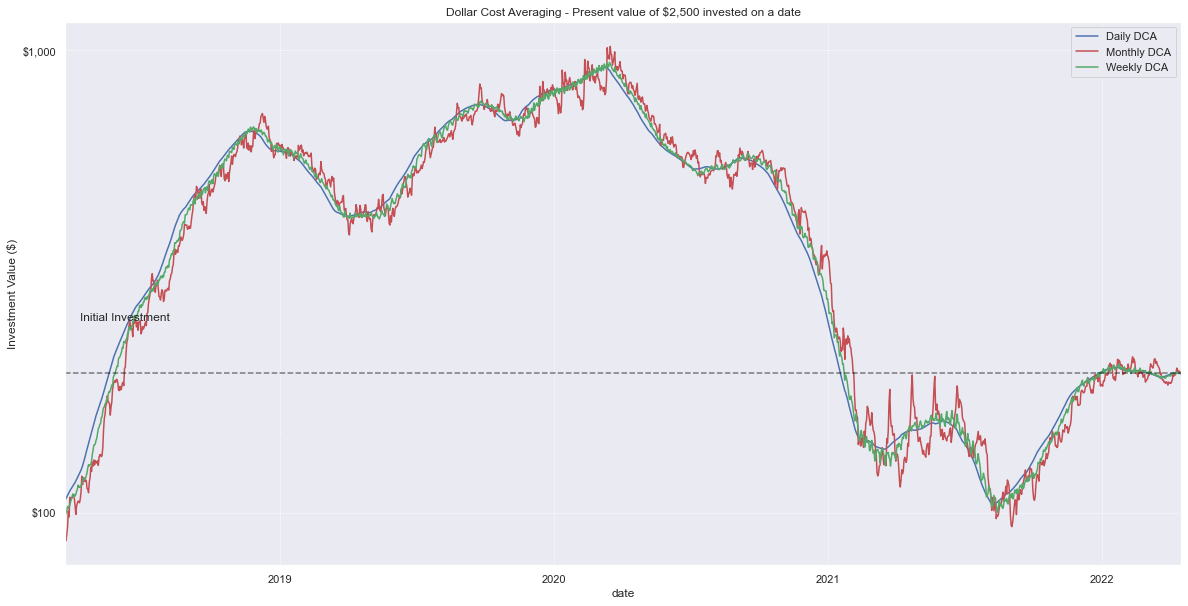

In [33]:
ax = plt.subplot()
dca[1:].plot(ax=ax, figsize=(20,10), color=['b','r','g'], label="DCA")

ax.set_yscale('log')
plt.grid(linestyle='dotted')
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: '${:,.0f}'.format(x)))

ax.axhline(initial_investment, alpha=0.5, linestyle="--", color="black")
ax.text(btc.index[20],initial_investment*1.3, "Initial Investment")
plt.title('Dollar Cost Averaging - Present value of $2,500 invested on a date')
plt.ylabel('Investment Value ($)')
plt.show()